In [ ]:
# Test 5-1 Dataset E
# Test to see if circle is present in the image

In [1]:
import numpy as np
import optuna as opt
from optuna.visualization import plot_optimization_history
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
tf.config.list_physical_devices('GPU')

2024-04-03 02:44:12.073193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 02:44:12.073222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 02:44:12.074750: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 02:44:12.083619: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 02:44:13.057325: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_dir = '../../Generator/Datasets/Dataset_E2/train'
test_dir = '../../Generator/Datasets/Dataset_E2/test'

In [3]:
IMG_SIZE = 250
BATCH_SIZE = 32

In [4]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    )

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    )

Found 3000 files belonging to 2 classes.


2024-04-03 02:44:19.837191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 02:44:19.837578: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-03 02:44:19.837834: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1000 files belonging to 2 classes.


In [5]:
checkpoint_filepath = 'models/5-1_optuna/ch-{epoch:03d}.ckpt'
callbacks = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)

In [7]:
def objective(trial):
    opt_num_hidden_dense_units = trial.suggest_int("opt_num_hidden_dense_units", 10, 512)
    opt_lr = trial.suggest_float("opt_lr", 1e-6, 1e-2, log=True)
    opt_bs = trial.suggest_int("opt_bs", 16, 128)
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=4, kernel_size=4, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=8, kernel_size=4, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=8, kernel_size=4, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=16, kernel_size=4, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(opt_num_hidden_dense_units, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.RMSprop(opt_lr), metrics=['acc'])
    history = model.fit(train_dataset, epochs=10, batch_size=opt_bs, validation_data=test_dataset, callbacks=[callbacks])
    min_val_loss = np.amin(history.history["val_loss"])
    return min_val_loss

In [8]:
study = opt.create_study()
study.optimize(objective, n_trials=15)

[I 2024-04-03 02:44:46,499] A new study created in memory with name: no-name-17e0bfb6-cbf5-45d6-8d68-a7c6e40e405a


Epoch 1/10


2024-04-03 02:44:48.109018: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-03 02:44:48.231864: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 02:44:50.080869: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0d4c31f970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 02:44:50.080932: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2024-04-03 02:44:50.088029: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712108690.147024  120442 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 [==============================] - ETA: 0s - loss: 0.6894 - acc: 0.6757
Epoch 1: val_loss improved from inf to 0.68645, saving model to models/5-1_optuna/ch-001.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-001.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-001.ckpt/assets


94/94 [==============================] - 12s 75ms/step - loss: 0.6894 - acc: 0.6757 - val_loss: 0.6865 - val_acc: 0.7100
Epoch 2/10
92/94 [============================>.] - ETA: 0s - loss: 0.6791 - acc: 0.7045
Epoch 2: val_loss improved from 0.68645 to 0.67210, saving model to models/5-1_optuna/ch-002.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-002.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-002.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.6788 - acc: 0.7043 - val_loss: 0.6721 - val_acc: 0.7160
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6624 - acc: 0.7143
Epoch 3: val_loss improved from 0.67210 to 0.65815, saving model to models/5-1_optuna/ch-003.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-003.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-003.ckpt/assets


94/94 [==============================] - 6s 61ms/step - loss: 0.6613 - acc: 0.7167 - val_loss: 0.6581 - val_acc: 0.7090
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.6486 - acc: 0.7347
Epoch 4: val_loss improved from 0.65815 to 0.64866, saving model to models/5-1_optuna/ch-004.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


94/94 [==============================] - 6s 57ms/step - loss: 0.6486 - acc: 0.7330 - val_loss: 0.6487 - val_acc: 0.7350
Epoch 5/10
93/94 [============================>.] - ETA: 0s - loss: 0.6416 - acc: 0.7406
Epoch 5: val_loss improved from 0.64866 to 0.64349, saving model to models/5-1_optuna/ch-005.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


94/94 [==============================] - 6s 62ms/step - loss: 0.6419 - acc: 0.7400 - val_loss: 0.6435 - val_acc: 0.7480
Epoch 6/10
93/94 [============================>.] - ETA: 0s - loss: 0.6373 - acc: 0.7413
Epoch 6: val_loss improved from 0.64349 to 0.63965, saving model to models/5-1_optuna/ch-006.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


94/94 [==============================] - 6s 56ms/step - loss: 0.6375 - acc: 0.7413 - val_loss: 0.6396 - val_acc: 0.7450
Epoch 7/10
93/94 [============================>.] - ETA: 0s - loss: 0.6338 - acc: 0.7419
Epoch 7: val_loss improved from 0.63965 to 0.63545, saving model to models/5-1_optuna/ch-007.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


94/94 [==============================] - 6s 65ms/step - loss: 0.6338 - acc: 0.7423 - val_loss: 0.6355 - val_acc: 0.7460
Epoch 8/10
92/94 [============================>.] - ETA: 0s - loss: 0.6309 - acc: 0.7432
Epoch 8: val_loss improved from 0.63545 to 0.63187, saving model to models/5-1_optuna/ch-008.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


94/94 [==============================] - 6s 57ms/step - loss: 0.6303 - acc: 0.7440 - val_loss: 0.6319 - val_acc: 0.7430
Epoch 9/10
92/94 [============================>.] - ETA: 0s - loss: 0.6270 - acc: 0.7398
Epoch 9: val_loss did not improve from 0.63187
94/94 [==============================] - 5s 49ms/step - loss: 0.6265 - acc: 0.7413 - val_loss: 0.6352 - val_acc: 0.7280
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.6241 - acc: 0.7378
Epoch 10: val_loss improved from 0.63187 to 0.62445, saving model to models/5-1_optuna/ch-010.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


94/94 [==============================] - 6s 63ms/step - loss: 0.6233 - acc: 0.7403 - val_loss: 0.6245 - val_acc: 0.7430


[I 2024-04-03 02:45:55,092] Trial 0 finished with value: 0.6244527101516724 and parameters: {'opt_num_hidden_dense_units': 254, 'opt_lr': 5.06569341177556e-05, 'opt_bs': 104}. Best is trial 0 with value: 0.6244527101516724.


Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 0.6906 - acc: 0.4997
Epoch 1: val_loss did not improve from 0.62445
94/94 [==============================] - 6s 50ms/step - loss: 0.6906 - acc: 0.4997 - val_loss: 0.6861 - val_acc: 0.5000
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6779 - acc: 0.5689
Epoch 2: val_loss did not improve from 0.62445
94/94 [==============================] - 5s 46ms/step - loss: 0.6778 - acc: 0.5690 - val_loss: 0.6676 - val_acc: 0.6160
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 0.6458 - acc: 0.6570
Epoch 3: val_loss did not improve from 0.62445
94/94 [==============================] - 5s 47ms/step - loss: 0.6458 - acc: 0.6570 - val_loss: 0.6364 - val_acc: 0.6520
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6160 - acc: 0.7060
Epoch 4: val_loss improved from 0.62445 to 0.61529, saving model to models/5-1_optuna/ch-004.ckpt
INFO:tensorflow:Assets written to: models/5-1

INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


94/94 [==============================] - 6s 60ms/step - loss: 0.6155 - acc: 0.7060 - val_loss: 0.6153 - val_acc: 0.7250
Epoch 5/10
93/94 [============================>.] - ETA: 0s - loss: 0.6025 - acc: 0.7040
Epoch 5: val_loss improved from 0.61529 to 0.60026, saving model to models/5-1_optuna/ch-005.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


94/94 [==============================] - 6s 58ms/step - loss: 0.6017 - acc: 0.7050 - val_loss: 0.6003 - val_acc: 0.6960
Epoch 6/10
92/94 [============================>.] - ETA: 0s - loss: 0.5932 - acc: 0.7133
Epoch 6: val_loss did not improve from 0.60026
94/94 [==============================] - 5s 46ms/step - loss: 0.5940 - acc: 0.7130 - val_loss: 0.6138 - val_acc: 0.6680
Epoch 7/10
93/94 [============================>.] - ETA: 0s - loss: 0.5858 - acc: 0.7107
Epoch 7: val_loss improved from 0.60026 to 0.58966, saving model to models/5-1_optuna/ch-007.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


94/94 [==============================] - 6s 58ms/step - loss: 0.5844 - acc: 0.7120 - val_loss: 0.5897 - val_acc: 0.7050
Epoch 8/10
94/94 [==============================] - ETA: 0s - loss: 0.5783 - acc: 0.7063
Epoch 8: val_loss improved from 0.58966 to 0.58253, saving model to models/5-1_optuna/ch-008.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


94/94 [==============================] - 6s 56ms/step - loss: 0.5783 - acc: 0.7063 - val_loss: 0.5825 - val_acc: 0.6990
Epoch 9/10
93/94 [============================>.] - ETA: 0s - loss: 0.5717 - acc: 0.7103
Epoch 9: val_loss improved from 0.58253 to 0.57621, saving model to models/5-1_optuna/ch-009.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-009.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-009.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.5714 - acc: 0.7103 - val_loss: 0.5762 - val_acc: 0.7190
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.5650 - acc: 0.7164
Epoch 10: val_loss improved from 0.57621 to 0.57598, saving model to models/5-1_optuna/ch-010.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


94/94 [==============================] - 6s 58ms/step - loss: 0.5648 - acc: 0.7177 - val_loss: 0.5760 - val_acc: 0.6950


[I 2024-04-03 02:46:49,951] Trial 1 finished with value: 0.5759793519973755 and parameters: {'opt_num_hidden_dense_units': 21, 'opt_lr': 0.00014781481151701967, 'opt_bs': 26}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.6933 - acc: 0.4915
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 6s 48ms/step - loss: 0.6935 - acc: 0.4897 - val_loss: 0.6933 - val_acc: 0.4530
Epoch 2/10
92/94 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.4861
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 42ms/step - loss: 0.6931 - acc: 0.4867 - val_loss: 0.6930 - val_acc: 0.4560
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.6936 - acc: 0.4845
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 46ms/step - loss: 0.6937 - acc: 0.4830 - val_loss: 0.6927 - val_acc: 0.4570
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6926 - acc: 0.4929
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6927 - acc: 0.4920 - val_loss: 0

[I 2024-04-03 02:47:36,333] Trial 2 finished with value: 0.6910272836685181 and parameters: {'opt_num_hidden_dense_units': 441, 'opt_lr': 2.632315316012288e-06, 'opt_bs': 33}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.6918 - acc: 0.4997
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 6s 45ms/step - loss: 0.6919 - acc: 0.4997 - val_loss: 0.6916 - val_acc: 0.4960
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6914 - acc: 0.5118
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 50ms/step - loss: 0.6914 - acc: 0.5117 - val_loss: 0.6915 - val_acc: 0.4970
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.6910 - acc: 0.5027
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 52ms/step - loss: 0.6910 - acc: 0.5030 - val_loss: 0.6913 - val_acc: 0.4980
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6911 - acc: 0.5091
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 53ms/step - loss: 0.6911 - acc: 0.5083 - val_loss: 0

[I 2024-04-03 02:48:27,495] Trial 3 finished with value: 0.6902658939361572 and parameters: {'opt_num_hidden_dense_units': 462, 'opt_lr': 1.0159524839499078e-06, 'opt_bs': 85}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.6922 - acc: 0.5034
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 7s 56ms/step - loss: 0.6923 - acc: 0.5027 - val_loss: 0.6919 - val_acc: 0.5400
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6927 - acc: 0.4940
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 46ms/step - loss: 0.6928 - acc: 0.4937 - val_loss: 0.6915 - val_acc: 0.5220
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.6918 - acc: 0.5192
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 50ms/step - loss: 0.6920 - acc: 0.5183 - val_loss: 0.6911 - val_acc: 0.4970
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6916 - acc: 0.5054
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6917 - acc: 0.5050 - val_loss: 0

[I 2024-04-03 02:49:18,755] Trial 4 finished with value: 0.6884282231330872 and parameters: {'opt_num_hidden_dense_units': 413, 'opt_lr': 3.28745327756644e-06, 'opt_bs': 89}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.6932 - acc: 0.5192
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 6s 45ms/step - loss: 0.6933 - acc: 0.5183 - val_loss: 0.6907 - val_acc: 0.5560
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6878 - acc: 0.5454
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 44ms/step - loss: 0.6877 - acc: 0.5463 - val_loss: 0.6832 - val_acc: 0.6120
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.6779 - acc: 0.6035
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 46ms/step - loss: 0.6778 - acc: 0.6040 - val_loss: 0.6719 - val_acc: 0.6220
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.6670 - acc: 0.6379
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6662 - acc: 0.6407 - val_loss: 0

[I 2024-04-03 02:50:05,183] Trial 5 finished with value: 0.6113100647926331 and parameters: {'opt_num_hidden_dense_units': 243, 'opt_lr': 7.053501938507429e-05, 'opt_bs': 112}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.6976 - acc: 0.5115
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 7s 50ms/step - loss: 0.6975 - acc: 0.5113 - val_loss: 0.6948 - val_acc: 0.5050
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6928 - acc: 0.5114
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6929 - acc: 0.5110 - val_loss: 0.6943 - val_acc: 0.5080
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6891 - acc: 0.5353
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 44ms/step - loss: 0.6891 - acc: 0.5363 - val_loss: 0.6934 - val_acc: 0.5040
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.6912 - acc: 0.5156
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6912 - acc: 0.5157 - val_loss: 0

[I 2024-04-03 02:50:53,577] Trial 6 finished with value: 0.6624350547790527 and parameters: {'opt_num_hidden_dense_units': 13, 'opt_lr': 6.492007373925729e-05, 'opt_bs': 117}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.6959 - acc: 0.4976
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 7s 59ms/step - loss: 0.6958 - acc: 0.4977 - val_loss: 0.6932 - val_acc: 0.4660
Epoch 2/10
92/94 [============================>.] - ETA: 0s - loss: 0.6962 - acc: 0.5003
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 47ms/step - loss: 0.6962 - acc: 0.5007 - val_loss: 0.6922 - val_acc: 0.4580
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6919 - acc: 0.5194
Epoch 3: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 48ms/step - loss: 0.6922 - acc: 0.5183 - val_loss: 0.6913 - val_acc: 0.4680
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6943 - acc: 0.5124
Epoch 4: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 50ms/step - loss: 0.6944 - acc: 0.5120 - val_loss: 0

[I 2024-04-03 02:51:47,293] Trial 7 finished with value: 0.6837165951728821 and parameters: {'opt_num_hidden_dense_units': 27, 'opt_lr': 1.8753279403802437e-05, 'opt_bs': 34}. Best is trial 1 with value: 0.5759793519973755.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.6642 - acc: 0.6525
Epoch 1: val_loss did not improve from 0.57598
94/94 [==============================] - 5s 43ms/step - loss: 0.6634 - acc: 0.6553 - val_loss: 0.6405 - val_acc: 0.7470
Epoch 2/10
92/94 [============================>.] - ETA: 0s - loss: 0.6184 - acc: 0.7422
Epoch 2: val_loss did not improve from 0.57598
94/94 [==============================] - 4s 42ms/step - loss: 0.6183 - acc: 0.7413 - val_loss: 0.6051 - val_acc: 0.7090
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.5722 - acc: 0.7235
Epoch 3: val_loss improved from 0.57598 to 0.56683, saving model to models/5-1_optuna/ch-003.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-003.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-003.ckpt/assets


94/94 [==============================] - 5s 56ms/step - loss: 0.5717 - acc: 0.7233 - val_loss: 0.5668 - val_acc: 0.7360
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.5251 - acc: 0.7325
Epoch 4: val_loss improved from 0.56683 to 0.53613, saving model to models/5-1_optuna/ch-004.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


94/94 [==============================] - 5s 55ms/step - loss: 0.5238 - acc: 0.7330 - val_loss: 0.5361 - val_acc: 0.7440
Epoch 5/10
94/94 [==============================] - ETA: 0s - loss: 0.5050 - acc: 0.7440
Epoch 5: val_loss improved from 0.53613 to 0.50103, saving model to models/5-1_optuna/ch-005.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.5050 - acc: 0.7440 - val_loss: 0.5010 - val_acc: 0.7310
Epoch 6/10
93/94 [============================>.] - ETA: 0s - loss: 0.4819 - acc: 0.7480
Epoch 6: val_loss improved from 0.50103 to 0.48527, saving model to models/5-1_optuna/ch-006.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.4813 - acc: 0.7490 - val_loss: 0.4853 - val_acc: 0.7470
Epoch 7/10
92/94 [============================>.] - ETA: 0s - loss: 0.4652 - acc: 0.7612
Epoch 7: val_loss improved from 0.48527 to 0.48275, saving model to models/5-1_optuna/ch-007.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


94/94 [==============================] - 6s 61ms/step - loss: 0.4676 - acc: 0.7610 - val_loss: 0.4827 - val_acc: 0.7490
Epoch 8/10
93/94 [============================>.] - ETA: 0s - loss: 0.4489 - acc: 0.7732
Epoch 8: val_loss improved from 0.48275 to 0.46935, saving model to models/5-1_optuna/ch-008.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-008.ckpt/assets


94/94 [==============================] - 5s 53ms/step - loss: 0.4478 - acc: 0.7737 - val_loss: 0.4694 - val_acc: 0.7570
Epoch 9/10
93/94 [============================>.] - ETA: 0s - loss: 0.4285 - acc: 0.7883
Epoch 9: val_loss improved from 0.46935 to 0.45085, saving model to models/5-1_optuna/ch-009.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-009.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-009.ckpt/assets


94/94 [==============================] - 5s 53ms/step - loss: 0.4277 - acc: 0.7887 - val_loss: 0.4509 - val_acc: 0.7770
Epoch 10/10
93/94 [============================>.] - ETA: 0s - loss: 0.4137 - acc: 0.8058
Epoch 10: val_loss improved from 0.45085 to 0.44859, saving model to models/5-1_optuna/ch-010.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-010.ckpt/assets


94/94 [==============================] - 5s 53ms/step - loss: 0.4149 - acc: 0.8053 - val_loss: 0.4486 - val_acc: 0.7750


[I 2024-04-03 02:52:46,185] Trial 8 finished with value: 0.4485880136489868 and parameters: {'opt_num_hidden_dense_units': 391, 'opt_lr': 0.0005142683811131112, 'opt_bs': 128}. Best is trial 8 with value: 0.4485880136489868.


Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 0.6937 - acc: 0.4920
Epoch 1: val_loss did not improve from 0.44859
94/94 [==============================] - 6s 47ms/step - loss: 0.6937 - acc: 0.4920 - val_loss: 0.6924 - val_acc: 0.4980
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6937 - acc: 0.4916
Epoch 2: val_loss did not improve from 0.44859
94/94 [==============================] - 4s 45ms/step - loss: 0.6936 - acc: 0.4920 - val_loss: 0.6923 - val_acc: 0.4990
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6946 - acc: 0.4817
Epoch 3: val_loss did not improve from 0.44859
94/94 [==============================] - 5s 46ms/step - loss: 0.6945 - acc: 0.4830 - val_loss: 0.6921 - val_acc: 0.4990
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.6937 - acc: 0.4871
Epoch 4: val_loss did not improve from 0.44859
94/94 [==============================] - 4s 43ms/step - loss: 0.6937 - acc: 0.4883 - val_loss: 0

[I 2024-04-03 02:53:33,173] Trial 9 finished with value: 0.6909499168395996 and parameters: {'opt_num_hidden_dense_units': 257, 'opt_lr': 1.6689791483663455e-06, 'opt_bs': 109}. Best is trial 8 with value: 0.4485880136489868.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.7948 - acc: 0.6200
Epoch 1: val_loss did not improve from 0.44859
94/94 [==============================] - 6s 44ms/step - loss: 0.7926 - acc: 0.6210 - val_loss: 0.5889 - val_acc: 0.6550
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.5639 - acc: 0.7120
Epoch 2: val_loss did not improve from 0.44859
94/94 [==============================] - 4s 44ms/step - loss: 0.5628 - acc: 0.7130 - val_loss: 0.5027 - val_acc: 0.7550
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: 0.5138 - acc: 0.7510
Epoch 3: val_loss did not improve from 0.44859
94/94 [==============================] - 4s 43ms/step - loss: 0.5133 - acc: 0.7513 - val_loss: 0.5150 - val_acc: 0.7800
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.4194 - acc: 0.8186
Epoch 4: val_loss improved from 0.44859 to 0.35168, saving model to models/5-1_optuna/ch-004.ckpt
INFO:tensorflow:Assets written to: models/5-1

INFO:tensorflow:Assets written to: models/5-1_optuna/ch-004.ckpt/assets


94/94 [==============================] - 5s 53ms/step - loss: 0.4178 - acc: 0.8190 - val_loss: 0.3517 - val_acc: 0.8740
Epoch 5/10
92/94 [============================>.] - ETA: 0s - loss: 0.3345 - acc: 0.8699
Epoch 5: val_loss improved from 0.35168 to 0.30353, saving model to models/5-1_optuna/ch-005.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-005.ckpt/assets


94/94 [==============================] - 5s 56ms/step - loss: 0.3325 - acc: 0.8703 - val_loss: 0.3035 - val_acc: 0.8900
Epoch 6/10
94/94 [==============================] - ETA: 0s - loss: 0.2796 - acc: 0.8993
Epoch 6: val_loss improved from 0.30353 to 0.29874, saving model to models/5-1_optuna/ch-006.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-006.ckpt/assets


94/94 [==============================] - 5s 54ms/step - loss: 0.2796 - acc: 0.8993 - val_loss: 0.2987 - val_acc: 0.9030
Epoch 7/10
92/94 [============================>.] - ETA: 0s - loss: 0.2630 - acc: 0.9032
Epoch 7: val_loss improved from 0.29874 to 0.28843, saving model to models/5-1_optuna/ch-007.ckpt
INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1_optuna/ch-007.ckpt/assets


94/94 [==============================] - 5s 54ms/step - loss: 0.2617 - acc: 0.9033 - val_loss: 0.2884 - val_acc: 0.9070
Epoch 8/10
92/94 [============================>.] - ETA: 0s - loss: 0.2424 - acc: 0.9147
Epoch 8: val_loss did not improve from 0.28843
94/94 [==============================] - 5s 46ms/step - loss: 0.2404 - acc: 0.9157 - val_loss: 0.3492 - val_acc: 0.8990
Epoch 9/10
93/94 [============================>.] - ETA: 0s - loss: 0.2240 - acc: 0.9217
Epoch 9: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.2254 - acc: 0.9213 - val_loss: 0.5278 - val_acc: 0.7740
Epoch 10/10
92/94 [============================>.] - ETA: 0s - loss: 0.1826 - acc: 0.9368
Epoch 10: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.1833 - acc: 0.9370 - val_loss: 0.3166 - val_acc: 0.8940


[I 2024-04-03 02:54:22,087] Trial 10 finished with value: 0.2884315252304077 and parameters: {'opt_num_hidden_dense_units': 352, 'opt_lr': 0.0040764534079202296, 'opt_bs': 58}. Best is trial 10 with value: 0.2884315252304077.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.9212 - acc: 0.5239
Epoch 1: val_loss did not improve from 0.28843
94/94 [==============================] - 6s 49ms/step - loss: 0.9193 - acc: 0.5250 - val_loss: 0.6946 - val_acc: 0.5160
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6583 - acc: 0.6468
Epoch 2: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 45ms/step - loss: 0.6580 - acc: 0.6463 - val_loss: 0.5838 - val_acc: 0.7270
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.5816 - acc: 0.7014
Epoch 3: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.5843 - acc: 0.6993 - val_loss: 0.6525 - val_acc: 0.7130
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.5601 - acc: 0.7117
Epoch 4: val_loss did not improve from 0.28843
94/94 [==============================] - 5s 47ms/step - loss: 0.5608 - acc: 0.7107 - val_loss: 0

[I 2024-04-03 02:55:08,695] Trial 11 finished with value: 0.35701191425323486 and parameters: {'opt_num_hidden_dense_units': 351, 'opt_lr': 0.003812987128689077, 'opt_bs': 55}. Best is trial 10 with value: 0.2884315252304077.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.7650 - acc: 0.5060
Epoch 1: val_loss did not improve from 0.28843
94/94 [==============================] - 6s 46ms/step - loss: 0.7646 - acc: 0.5047 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 2/10
92/94 [============================>.] - ETA: 0s - loss: 0.6950 - acc: 0.4915
Epoch 2: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.6951 - acc: 0.4897 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6939 - acc: 0.4885
Epoch 3: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 43ms/step - loss: 0.6939 - acc: 0.4887 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.6943 - acc: 0.5027
Epoch 4: val_loss did not improve from 0.28843
94/94 [==============================] - 5s 47ms/step - loss: 0.6943 - acc: 0.5023 - val_loss: 0

[I 2024-04-03 02:55:54,489] Trial 12 finished with value: 0.693149209022522 and parameters: {'opt_num_hidden_dense_units': 327, 'opt_lr': 0.007995447494835143, 'opt_bs': 55}. Best is trial 10 with value: 0.2884315252304077.


Epoch 1/10
92/94 [============================>.] - ETA: 0s - loss: 0.9117 - acc: 0.4942
Epoch 1: val_loss did not improve from 0.28843
94/94 [==============================] - 6s 46ms/step - loss: 0.9076 - acc: 0.4963 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.6937 - acc: 0.4899
Epoch 2: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 45ms/step - loss: 0.6937 - acc: 0.4887 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 3/10
92/94 [============================>.] - ETA: 0s - loss: 0.6935 - acc: 0.4898
Epoch 3: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.6935 - acc: 0.4873 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/10
92/94 [============================>.] - ETA: 0s - loss: 0.6935 - acc: 0.4857
Epoch 4: val_loss did not improve from 0.28843
94/94 [==============================] - 5s 45ms/step - loss: 0.6935 - acc: 0.4853 - val_loss: 0

[I 2024-04-03 02:56:42,072] Trial 13 finished with value: 0.6931485533714294 and parameters: {'opt_num_hidden_dense_units': 339, 'opt_lr': 0.008421281849991316, 'opt_bs': 57}. Best is trial 10 with value: 0.2884315252304077.


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: 0.6531 - acc: 0.6448
Epoch 1: val_loss did not improve from 0.28843
94/94 [==============================] - 6s 45ms/step - loss: 0.6527 - acc: 0.6457 - val_loss: 0.6274 - val_acc: 0.6160
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: 0.5709 - acc: 0.7067
Epoch 2: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 43ms/step - loss: 0.5708 - acc: 0.7060 - val_loss: 0.5507 - val_acc: 0.7040
Epoch 3/10
94/94 [==============================] - ETA: 0s - loss: 0.5253 - acc: 0.7250
Epoch 3: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 45ms/step - loss: 0.5253 - acc: 0.7250 - val_loss: 0.5191 - val_acc: 0.7300
Epoch 4/10
93/94 [============================>.] - ETA: 0s - loss: 0.5105 - acc: 0.7379
Epoch 4: val_loss did not improve from 0.28843
94/94 [==============================] - 4s 44ms/step - loss: 0.5101 - acc: 0.7390 - val_loss: 0

[I 2024-04-03 02:57:29,678] Trial 14 finished with value: 0.4332897663116455 and parameters: {'opt_num_hidden_dense_units': 167, 'opt_lr': 0.0015444589512302795, 'opt_bs': 60}. Best is trial 10 with value: 0.2884315252304077.


In [9]:
plot_optimization_history(study)

In [10]:
from optuna.visualization import plot_contour
plot_contour(study, params=["opt_lr", "opt_bs"])

In [11]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [12]:
best_params = study.best_params
found_opt_num_hidden_dense_units = best_params["opt_num_hidden_dense_units"]
found_opt_lr = best_params["opt_lr"]
found_opt_bs = best_params["opt_bs"]
print("Found num hidden dense units: {}".format(found_opt_num_hidden_dense_units))
print("Found learning rate: {}".format(found_opt_lr))
print("Found batch size: {}".format(found_opt_bs))

Found num hidden dense units: 352
Found learning rate: 0.0040764534079202296
Found batch size: 58


In [13]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=4, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=8, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=8, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=16, kernel_size=4, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(found_opt_num_hidden_dense_units, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [14]:
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=found_opt_lr), 
    metrics=['acc'])

In [15]:
checkpoint_filepath = 'models/5-1/ch-{epoch:03d}.ckpt'
callbacks = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
#Best Epoch = ?

history = model.fit(train_dataset, epochs=40, batch_size=found_opt_bs, validation_data=test_dataset, callbacks=[callbacks,early_stop])

Epoch 1/40


93/94 [============================>.] - ETA: 0s - loss: 0.7474 - acc: 0.4976
Epoch 1: val_loss improved from inf to 0.69189, saving model to models/5-1/ch-001.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-001.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-001.ckpt/assets


94/94 [==============================] - 8s 64ms/step - loss: 0.7471 - acc: 0.4957 - val_loss: 0.6919 - val_acc: 0.5460
Epoch 2/40
92/94 [============================>.] - ETA: 0s - loss: 0.6553 - acc: 0.6566
Epoch 2: val_loss improved from 0.69189 to 0.64009, saving model to models/5-1/ch-002.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-002.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-002.ckpt/assets


94/94 [==============================] - 6s 63ms/step - loss: 0.6529 - acc: 0.6583 - val_loss: 0.6401 - val_acc: 0.5930
Epoch 3/40
92/94 [============================>.] - ETA: 0s - loss: 0.5304 - acc: 0.7554
Epoch 3: val_loss improved from 0.64009 to 0.45306, saving model to models/5-1/ch-003.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-003.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-003.ckpt/assets


94/94 [==============================] - 5s 54ms/step - loss: 0.5293 - acc: 0.7553 - val_loss: 0.4531 - val_acc: 0.8260
Epoch 4/40
93/94 [============================>.] - ETA: 0s - loss: 0.4211 - acc: 0.8202
Epoch 4: val_loss improved from 0.45306 to 0.39314, saving model to models/5-1/ch-004.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-004.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-004.ckpt/assets


94/94 [==============================] - 6s 61ms/step - loss: 0.4198 - acc: 0.8210 - val_loss: 0.3931 - val_acc: 0.8440
Epoch 5/40
94/94 [==============================] - ETA: 0s - loss: 0.3194 - acc: 0.8783
Epoch 5: val_loss improved from 0.39314 to 0.37001, saving model to models/5-1/ch-005.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-005.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-005.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.3194 - acc: 0.8783 - val_loss: 0.3700 - val_acc: 0.8500
Epoch 6/40
92/94 [============================>.] - ETA: 0s - loss: 0.2673 - acc: 0.9012
Epoch 6: val_loss improved from 0.37001 to 0.29269, saving model to models/5-1/ch-006.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-006.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-006.ckpt/assets


94/94 [==============================] - 6s 58ms/step - loss: 0.2661 - acc: 0.9013 - val_loss: 0.2927 - val_acc: 0.8960
Epoch 7/40
93/94 [============================>.] - ETA: 0s - loss: 0.2382 - acc: 0.9160
Epoch 7: val_loss improved from 0.29269 to 0.27242, saving model to models/5-1/ch-007.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-007.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-007.ckpt/assets


94/94 [==============================] - 6s 61ms/step - loss: 0.2407 - acc: 0.9157 - val_loss: 0.2724 - val_acc: 0.9060
Epoch 8/40
92/94 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.9236
Epoch 8: val_loss did not improve from 0.27242
94/94 [==============================] - 5s 46ms/step - loss: 0.2069 - acc: 0.9243 - val_loss: 0.3124 - val_acc: 0.9070
Epoch 9/40
93/94 [============================>.] - ETA: 0s - loss: 0.2004 - acc: 0.9345
Epoch 9: val_loss improved from 0.27242 to 0.24593, saving model to models/5-1/ch-009.ckpt
INFO:tensorflow:Assets written to: models/5-1/ch-009.ckpt/assets


INFO:tensorflow:Assets written to: models/5-1/ch-009.ckpt/assets


94/94 [==============================] - 6s 59ms/step - loss: 0.2003 - acc: 0.9343 - val_loss: 0.2459 - val_acc: 0.9160
Epoch 10/40
93/94 [============================>.] - ETA: 0s - loss: 0.1522 - acc: 0.9435
Epoch 10: val_loss did not improve from 0.24593
94/94 [==============================] - 5s 49ms/step - loss: 0.1517 - acc: 0.9437 - val_loss: 0.2519 - val_acc: 0.9180
Epoch 11/40
93/94 [============================>.] - ETA: 0s - loss: 0.1481 - acc: 0.9449
Epoch 11: val_loss did not improve from 0.24593
94/94 [==============================] - 5s 46ms/step - loss: 0.1473 - acc: 0.9453 - val_loss: 0.3101 - val_acc: 0.9230
Epoch 12/40
92/94 [============================>.] - ETA: 0s - loss: 0.1369 - acc: 0.9545
Epoch 12: val_loss did not improve from 0.24593
94/94 [==============================] - 4s 43ms/step - loss: 0.1351 - acc: 0.9553 - val_loss: 0.3048 - val_acc: 0.9330
Epoch 13/40
94/94 [==============================] - ETA: 0s - loss: 0.1560 - acc: 0.9543
Epoch 13: val_lo

In [21]:
model.save('models/5-1/5-1-E.h5')

/home/fred/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [22]:
# print weights
for layer in model.layers:
    weights = layer.get_weights()
    print(weights)

[]
[]
[array([[[[-0.29912835, -0.19579819,  0.40471113, -0.09645652],
         [-0.11635174,  0.06084597,  0.1300671 , -0.1601791 ],
         [ 0.2264259 ,  0.15405354,  0.14159472, -0.5485701 ]],

        [[-0.22559229, -0.16200502,  0.21082866,  0.01834656],
         [-0.22144414, -0.23202749, -0.1833897 , -0.16162303],
         [-0.1732075 , -0.06173323, -0.06299909,  0.20765196]],

        [[-0.41743755, -0.01377664, -0.30919543, -0.01720738],
         [-0.03910001, -0.07205524, -0.39036974, -0.24869506],
         [ 0.23764072,  0.01040754, -0.28881806,  0.2512855 ]],

        [[-0.17044812,  0.01876623, -0.3238632 ,  0.11138159],
         [ 0.00445572, -0.08143798, -0.099054  ,  0.3426267 ],
         [ 0.17586546,  0.05658899,  0.23684287, -0.16246203]]],


       [[[-0.23262323,  0.09396009,  0.4461905 , -0.24122328],
         [-0.19730379, -0.12230551, -0.12442066, -0.25664794],
         [ 0.23450641,  0.15723744,  0.03016668,  0.251674  ]],

        [[-0.37076977, -0.04794919, 

In [23]:
val_loss, val_acc = model.evaluate(test_dataset, batch_size=32)
print(val_loss, val_acc)

32/32 [==============================] - 1s 27ms/step - loss: 0.6420 - acc: 0.9360
0.6420246958732605 0.9359999895095825


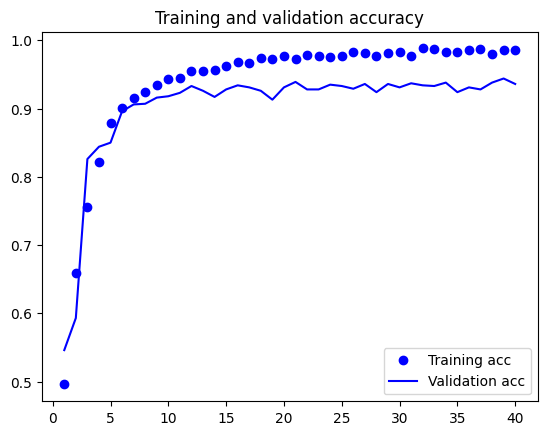

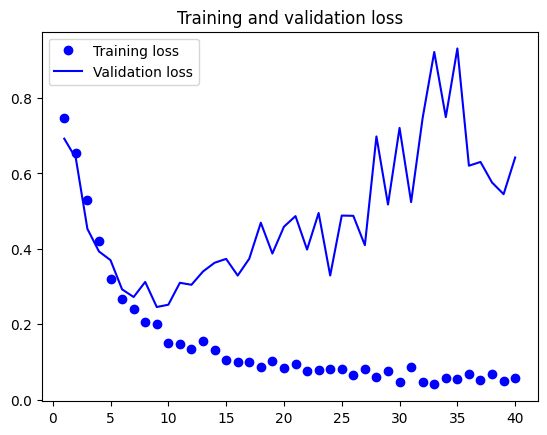

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("graphs/5-1/train_test_acc",dpi=100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("graphs/5-1/train_test_loss",dpi=100)
plt.show()


In [24]:
file_paths = []
wrong_filenames = []
count = 0
file_idx = 0

# make sure we start in the beginning
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    shuffle=False
    )
    
file_paths = test_dataset.file_paths
for data_batch, labels_batch in test_dataset:

    predictions = model.predict(data_batch).flatten()
    predictions = predictions.round()
    predictions = predictions.astype(int)
    labels_batch = labels_batch.numpy()
    #pred_str = np.array2string(predictions, separator=', ')
    #label_str = np.array2string(labels_batch, separator=', ')
    for i in range(len(data_batch)):
        if labels_batch[i] != predictions[i]:
            wrong_filenames.append(file_paths[file_idx])
    file_idx += 1

# print(f"Predictions: {pred_str}")
# print(f"Labels: {label_str}")
print(file_idx)
print(count)
print(len(wrong_filenames))

Found 1000 files belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step
1000
0
64


In [25]:
# write the wrong filenames to a file
with open('results/5-1/failed_filenames.txt', 'w') as f:
    for item in wrong_filenames:
        f.write("%s\n" % item)

In [26]:
failed_images_dataset = image_dataset_from_directory(
    'results/5-1/failed_images',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32)

val_loss, val_acc = model.evaluate(failed_images_dataset, batch_size=32)
print(val_loss, val_acc)

Found 64 files belonging to 2 classes.
2/2 [==============================] - 0s 17ms/step - loss: 9.8228 - acc: 0.0000e+00
9.822793960571289 0.0
